# 缠论编程实现

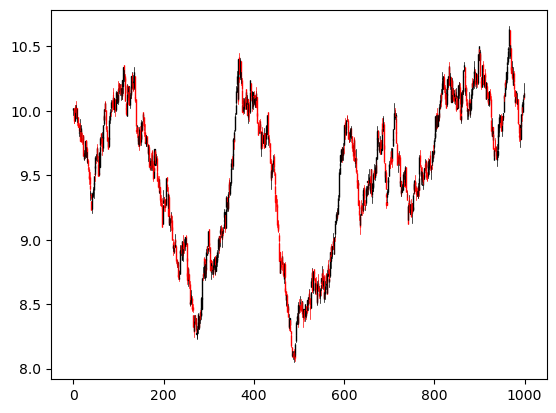

In [141]:
# 随机生成 1min KLine 作例子

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

N = 1000
px = (1+ np.cumsum(np.random.normal(0, 0.0015, 20 * N))) * 10
px = pd.Series(px)
opn = px.groupby(px.index // 20).first()
cls = px.groupby(px.index // 20).last()
hgh = px.groupby(px.index // 20).max()
low = px.groupby(px.index // 20).min()
ts = pd.Series(opn.index)

df_kline = pd.concat([ts.rename('time'), opn.rename('open'), hgh.rename('high'), low.rename('low'), cls.rename('close')], axis=1)

# plot
fig,ax = plt.subplots()
_ = candlestick_ohlc(ax, df_kline.values)

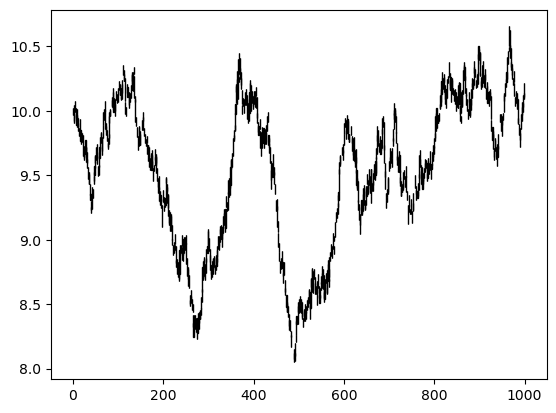

In [142]:
# 缠论 K 线

n = len(df_kline)

cklines = []

for i in range(n):
    t,low,hgh = df_kline.iloc[i][['time','low','high']]
    if len(cklines) == 0:
        cklines.append((t,low,hgh))
    elif len(cklines) == 1:
        pt, plow, phgh = cklines[-1]
        if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh):
            cklines[-1] = (t, max(plow,low), max(phgh, hgh))
        else:
            cklines.append((t,low,hgh))
    else:
        pt, plow, phgh = cklines[-1]
        if cklines[-1][2] > cklines[-2][2]: # up
            if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh): # up-up merge
                cklines[-1] = (t, max(plow,low), max(phgh, hgh))
            else:
                cklines.append((t, low, hgh))
 
        else: # down
            if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh): # low-low merge
                cklines[-1] = (t, min(plow,low), min(phgh, hgh))
            else:
                cklines.append((t, low, hgh))

# 缠论 K 线
df_ckline = pd.DataFrame(data=cklines, columns=['time','low','high'])

# 添加open/close只是为了作图
df_ckline['open'] = df_ckline['low']
df_ckline['close'] = df_ckline['high']


# plot
fig,ax = plt.subplots()
_ = candlestick_ohlc(ax, df_ckline.values)

In [143]:
# 顶/底分型

parts = []
for i in range(1, len(df_ckline)-1):
    pt, plow, phgh = df_ckline.iloc[i-1][['time', 'low','high']]
    t, low, hgh = df_ckline.iloc[i][['time','low','high']]
    nlow, nhgh = df_ckline.iloc[i+1][['low','high']]

    if i == 1: # 对于第0个元素，只看第1个元素跟其关系（当然也可以直接舍弃）
        if hgh > phgh:
            parts.append((-1, pt, plow, phgh))
        else:
            parts.append((1, pt, plow, phgh))

    if hgh > phgh and hgh > nhgh: # 顶分型
        parts.append((1,t,low,hgh))
    elif hgh < phgh and hgh < nhgh: # 底分型
        parts.append((-1,t,low,hgh))

df_part = pd.DataFrame(data=parts, columns=('type','time','low','high'))
df_part

,type,time,low,high
0,1,1.0,9.970177,10.024844
1,-1,2.0,9.907447,9.979592
2,1,5.0,9.994597,10.077050
3,-1,8.0,9.891501,9.967880
4,1,9.0,9.916288,10.014534
...,...,...,...,...
331,-1,983.0,10.017663,10.096117
332,1,984.0,10.055211,10.136466
333,-1,989.0,9.718025,9.829463
334,1,994.0,9.969076,10.071875


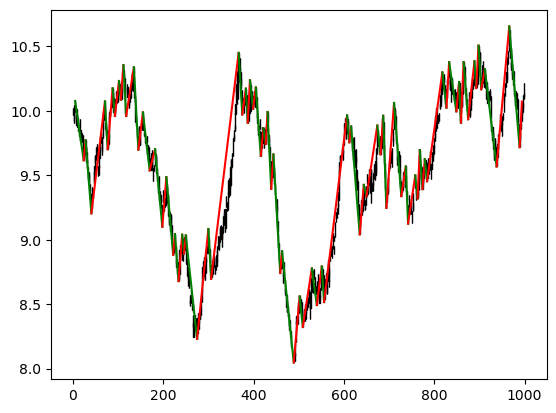

,di,t0,t1,px0,px1
0,-1,5.0,24.0,10.077050,9.616264
1,1,24.0,28.0,9.616264,9.772233
2,-1,28.0,41.0,9.772233,9.204213
3,1,41.0,71.0,9.204213,10.072943
4,-1,71.0,77.0,10.072943,9.702128
...,...,...,...,...,...
81,1,904.0,912.0,10.167323,10.324178
82,-1,912.0,938.0,10.324178,9.568141
83,1,938.0,966.0,9.568141,10.654777
84,-1,966.0,989.0,10.654777,9.718025


In [144]:
# 笔

biparts = []
for i in range(len(parts)):
    typ, t, low, hgh = parts[i]
    if len(biparts) == 0:
        biparts.append(parts[i])
    else:
        ptyp, pt, plow, phgh = biparts[-1]

        if (ptyp != typ) and (t-pt >= 4):
            biparts.append(parts[i])

        elif (ptyp == typ == 1) and (hgh >= phgh):
            biparts[-1] = parts[i]

        elif (ptyp == typ == -1) and (low <= plow):
            biparts[-1] = parts[i]


bis = []
for i in range(1, len(biparts)):
    typ0, t0, low0, hgh0 = biparts[i-1]
    typ1, t1, low1, hgh1 = biparts[i]

    px0 = low0 if typ0 == -1 else hgh0 
    px1 = low1 if typ1 == -1 else hgh1

    # 方向，1：向上，-1：向下
    di = 1 if px1 > px0 else -1
    
    bis.append((di, t0, t1, px0, px1))

# 笔
df_bi = pd.DataFrame(data=bis, columns=['di', 't0','t1','px0','px1'])


# plot
fig,ax = plt.subplots()
_ = candlestick_ohlc(ax, df_ckline.values)
for di,t0,t1,px0,px1 in df_bi.values:
    _ = ax.plot([t0,t1],[px0,px1],color=['','r','g'][int(di)])
plt.show()

df_bi

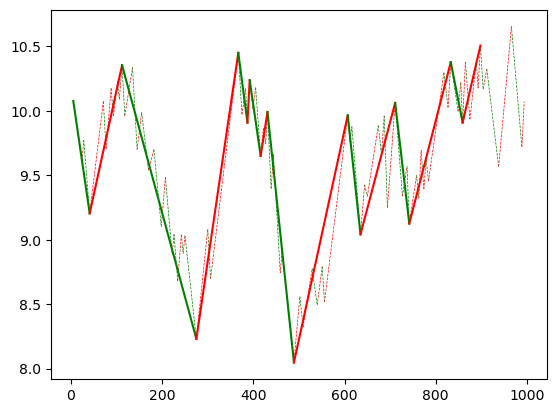

In [145]:
# 线段

segs = []

bis = df_bi.copy()
is_head = True

while len(bis) > 3:
    # B：序列开始位置
    if is_head:
        # 第1笔向上
        if bis.iloc[0].di == 1:

            s1,x1,s2,x2 = bis.iloc[0],bis.iloc[1],bis.iloc[2],bis.iloc[3]

            # B1-1: s1 作为第1段
            # B2-1: s1 作为第1段
            if (
                (s2.px1 < s1.px0) 
                or 
                (s2.px1 < s1.px1) 
            ):
                segs.append(tuple(s1))
                bis = bis.iloc[1:]


            # B3-1: x1,x2...寻找顶分型
            # B4-1: x1,x2...寻找顶分型
            elif (
                ((s2.px1 > s1.px1) and (x2.px1 < x1.px1)) 
                or 
                ((s2.px1 > s1.px1) and (x2.px1 > x1.px1)) 
            ):
                found = False
                plow,phgh = x2.px1,x2.px0
                for i in range(5,len(bis),2):
                    di,t0,t1,hgh,low = bis.iloc[i]

                    # 找到顶分型
                    if hgh < phgh and low < plow:
                        s_b, s_e = s1, bis.iloc[i-3] # 线段 开始/结尾 的向上笔
                        segs.append((1, s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                        
                        bis = bis.iloc[i-2:]
                        found = True

                        break
                    plow,phgh = max(plow,low),max(phgh,hgh)

                # 未找到底分型，结束
                if not found:
                    break

                is_head = False
            
            else: 
                raise Exception("some error")


        # 第1笔向下
        else: 
            x1,s1,x2,s2 = bis.iloc[0],bis.iloc[1],bis.iloc[2],bis.iloc[3]

            # B1-2: x1 作为第1段
            # B2-2: x1 作为第1段
            if (
                (x2.px1 > x1.px0) 
                or 
                (x2.px1 > x1.px1) 
            ):
                segs.append(tuple(x1))
                bis = bis.iloc[1:]


            # B3-2: s1,s2...寻找底分型
            # B4-2: s1,s2...寻找底分型
            elif (
                ((x2.px1 < x1.px1) and (s2.px1 > s1.px1)) 
                or 
                ((x2.px1 < x1.px1) and (s2.px1 < s1.px1)) 
            ):
                found = False
                plow,phgh = s2.px0,s2.px1
                for i in range(5,len(bis),2):
                    di,t0,t1,low,hgh = bis.iloc[i]

                    # 找到底分型
                    if low > plow and hgh > phgh:
                        s_b, s_e = x1, bis.iloc[i-3] # 线段 开始/结尾 的向下笔
                        segs.append((-1, s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                        
                        bis = bis.iloc[i-2:]
                        found = True

                        break
                    plow,phgh = min(plow,low),min(phgh,hgh)

                # 未找到底分型，结束
                if not found:
                    break

                is_head = False
            
            else: 
                raise Exception("some error")



    # A: 序列中间位置
    else:
        # 第1笔向上，x1,x2,...中寻找顶分型

        if bis.iloc[0].di == 1:
            s1,x1,s2 = bis.iloc[0],bis.iloc[1],bis.iloc[2]

            found = False
            plow,phgh = x1.px1,x1.px0
            for i in range(3,len(bis),2):
                di,t0,t1,hgh,low = bis.iloc[i]

                # 找到顶分型
                if hgh < phgh and low < plow:
                    s_b, s_e = s1, bis.iloc[i-3] # 线段 开始/结尾 的向上笔
                    segs.append((1, s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                    
                    bis = bis.iloc[i-2:]
                    found = True

                    break
                plow,phgh = max(plow,low),max(phgh,hgh)

            # 未找到顶分型，结束
            if not found:
                break


        # 第1笔向下，s1,s2,...中寻找底分型
        else:
            x1,s1,x2 = bis.iloc[0],bis.iloc[1],bis.iloc[2]

            found = False
            plow,phgh = s1.px0,s1.px1
            for i in range(3,len(bis),2):
                di,t0,t1,low,hgh = bis.iloc[i]

                # 找到底分型
                if low > plow and hgh > phgh:
                    s_b, s_e = x1, bis.iloc[i-3] # 线段 开始/结尾 的向下笔
                    segs.append((-1, s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                    
                    bis = bis.iloc[i-2:]
                    found = True

                    break
                plow,phgh = min(plow,low),min(phgh,hgh)

            # 未找到底分型，结束
            if not found:
                break



# 线段
df_seg = pd.DataFrame(data=segs, columns=['di', 't0','t1','px0','px1'])


# plot
fig,ax = plt.subplots()
#_ = candlestick_ohlc(ax, df_ckline.values)

# plot 笔
for di,t0,t1,px0,px1 in df_bi.values:
    _ = ax.plot([t0,t1],[px0,px1],'--',color=['','r','g'][int(di)], linewidth=0.5)

# plot 线段
for di,t0,t1,px0,px1 in df_seg.values:
    _ = ax.plot([t0,t1],[px0,px1],color=['','r','g'][int(di)], linewidth=1.5)

plt.show()

In [128]:
# 中枢